# Sentiment classification - close to the state of the art
The task of classifying sentiments of texts (for example movie or product reviews) has high practical significance in online marketing as well as financial prediction. This is a non-trivial task, since the concept of sentiment is not easily captured.

For this project we are using the larger IMDB sentiment benchmark dataset from Stanford, an achieve close to state of the art results.

The task is to try out multiple models in ascending complexity, namely:

1.TFIDF + classical statistical model (eg. RandomForest)

2.LSTM classification model

3.LSTM model, where the embeddings are initialized with pre-trained GloVe vectors

4.fastText model

5.BERT based model (we are advised to use a pre-trained one and finetune, since the resource consumption is considerable!)

## Import needed libraries

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
!pip3 install ktrain
from glob import glob
import numpy as np
import os,re
from pandas import DataFrame
import pandas as pd
import string
import matplotlib.pyplot as plt

from sklearn import decomposition, ensemble
from sklearn.model_selection import train_test_split
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
import spacy
from spacy.lang.en import English
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import spacy, logging, warnings
import gensim
from gensim import corpora


from IPython.display import HTML
#Keras
from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense , Input , LSTM , Embedding, Dropout , Activation, GRU, Flatten
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model, Sequential
from keras.layers import Conv1D, MaxPooling1D, Embedding, Flatten, LSTM
from keras.models import Model
from keras.initializers import Constant
#from keras import initializers, regularizers, optimizers, layer
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
import tensorflow_hub as hub

from tqdm import tqdm_notebook
from tensorflow.keras import backend as K
import tensorflow as tf

from bs4 import BeautifulSoup

import warnings
warnings.filterwarnings('ignore')

     |████████████████████████████████| 92kB 4.3MB/s 
     |████████████████████████████████| 1.0MB 14.0MB/s 
     |████████████████████████████████| 245kB 70.7MB/s 
     |████████████████████████████████| 1.8MB 65.3MB/s 
  Created wheel for ktrain: filename=ktrain-0.7.2-cp36-none-any.whl size=113492 sha256=337f6d071e09c4cc89ffdce7d6ede7ac2844bc9af34246904c6696efda75e4c4
  Stored in directory: /root/.cache/pip/wheels/ed/db/bd/fb2cb12563e8a7e5ef04f99cc9014bc0e509f1bb3834e6ee5d
  Created wheel for keras-bert: filename=keras_bert-0.80.0-cp36-none-any.whl size=37923 sha256=bde45a27b560da375defc897fd23a38984e09c1817e6148c07d638bfe36b3f6e
  Stored in directory: /root/.cache/pip/wheels/63/dc/87/3260cb91f3aa32c0f85c5375429a30c8fd988bbb48f5ee21b0
  Created wheel for langdetect: filename=langdetect-1.0.7-cp36-none-any.whl size=993460 sha256=5a09005318f413d90a668fbd7b1101ec87ab826a7f61534ccf8dce2e4e484651
  Stored in directory: /root/.cache/pip/wheels/ec/0c/a9/1647275e7ef5014e7b83ff30105180e33286

Using TensorFlow backend.


## Download dataset and load it in colab

In [2]:
# see what is in my directory

!ls

sample_data


In [3]:
# download the data via given link
! wget https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz 

--2019-12-21 22:07:55--  https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘aclImdb_v1.tar.gz’

aclImdb_v1.tar.gz   100%[===================>]  80.23M  67.9MB/s    in 1.2s    

2019-12-21 22:07:57 (67.9 MB/s) - ‘aclImdb_v1.tar.gz’ saved [84125825/84125825]



In [ ]:
#unzip the file
!gunzip aclImdb_v1.tar.gz
!tar -xvf aclImdb_v1.tar

In [0]:
MYPATH= 'aclImdb/' #set up the path.
Class = ['neg','pos'] #create a list which will be used later for the retrival of all data

In [6]:
# check if the file has been successfully downloaded and unzipped
!ls

aclImdb  aclImdb_v1.tar  sample_data


In [7]:
# show the content of my data folder
!ls {MYPATH}

imdbEr.txt  imdb.vocab	README	test  train


# EDA (Exploratory Data Analysis)

In [8]:
# see what is in the train folder
print('Train folder contains:')
!ls {MYPATH}train 
# train folder included both labeled neg and pos texts
print('\nSeveral text files in positive labeled train folder:')
!ls {MYPATH}train/pos | head 
print('\nSeveral text files in Negative labeled train folder:')
!ls {MYPATH}train/neg | head 

Train folder contains:
labeledBow.feat  pos	unsupBow.feat  urls_pos.txt
neg		 unsup	urls_neg.txt   urls_unsup.txt

Several text files in positive labeled train folder:
0_9.txt
10000_8.txt
10001_10.txt
10002_7.txt
10003_8.txt
10004_8.txt
10005_7.txt
10006_7.txt
10007_7.txt
10008_7.txt

Several text files in Negative labeled train folder:
0_3.txt
10000_4.txt
10001_4.txt
10002_1.txt
10003_1.txt
10004_3.txt
1000_4.txt
10005_3.txt
10006_4.txt
10007_1.txt


In [9]:
# see what is in the test folder
print('Test folder contains:')
!ls {MYPATH}test 
# test folder included both labeled neg and pos texts
print('\nSeveral text files in positive labeled test folder:')
!ls {MYPATH}test/pos | head 
print('\nSeveral text files in Negative labeled test folder:')
!ls {MYPATH}test/neg | head 

Test folder contains:
labeledBow.feat  neg  pos  urls_neg.txt  urls_pos.txt

Several text files in positive labeled test folder:
0_10.txt
10000_7.txt
10001_9.txt
10002_8.txt
10003_8.txt
10004_9.txt
10005_8.txt
10006_7.txt
10007_10.txt
10008_8.txt

Several text files in Negative labeled test folder:
0_2.txt
10000_4.txt
10001_1.txt
10002_3.txt
10003_3.txt
1000_3.txt
10004_2.txt
10005_2.txt
10006_2.txt
10007_4.txt


In [0]:
# define a function to retrieve and load the train and test data from above folders

def load_texts_labels_from_folders(path, folders):
    texts,labels = [],[]
    for idx,label in enumerate(folders):
        for fname in glob(os.path.join(path, label, '*.*')):
            texts.append(open(fname, 'r').read())
            labels.append(idx)
    # stored as np.int8 to save space 
    return texts, np.array(labels).astype(np.int8)

# store the loaded data under their respective names
x_train_ori,y_train_ori = load_texts_labels_from_folders(f'{MYPATH}train',Class)
x_test_ori,y_test_ori = load_texts_labels_from_folders(f'{MYPATH}test',Class)

In [11]:
# The data is split evenly with 25k reviews for training data and 25k for testing data.
print('Number of training: ', len(x_train_ori),'\nNumber of testing: ', len(x_test_ori))

Number of training:  25000 
Number of testing:  25000


In [12]:
# each training and testing set has evenly 12.5k positive and 12.5k negative reviews as well.
print('Number of positive reviews in training: ', len(y_train_ori[y_train_ori==1]),'\nNumber of positive reviews in testing: ',len(y_test_ori[y_test_ori==1]))

Number of positive reviews in training:  12500 
Number of positive reviews in testing:  12500


In [13]:
# see the first 5 reviews from training dataset and their corresponded labels
x_train_ori[:5]

["This is actually a pretty bad film. The ideology is not as perverse as in those films Collins made later. However, my main misgivings about the film are that it is implausible and quite frankly boring for a long time. The whole concept of an ex-SAS man joining terrorists for no particular reason isn't very convincing and you can't help wondering why a group of highly organized terrorists (who later become pretty clueless) fall for it. The film starts with a pretty powerful scene but then meanders for quite a long time building up towards the great finale. Overall, I think Who dares wins could have been an interesting 45 minutes episode of The Professionals but the story doesn't carry a feature film. Although reasonably successful at the time this film initiated the demise of Collins' career who in the eighties mainly made cheap and dubious soldier-of-fortune or army films. Pity, because he actually is quite a versatile actor but at the end of the day Martin Shaw chose his roles more 

In [14]:
y_train_ori[:5]
# according to given information of the dataset: 
#0 represents negative review, 1 represents postive. 
#This means that the above 5 reviews are all being labled as negative.

array([0, 0, 0, 0, 0], dtype=int8)

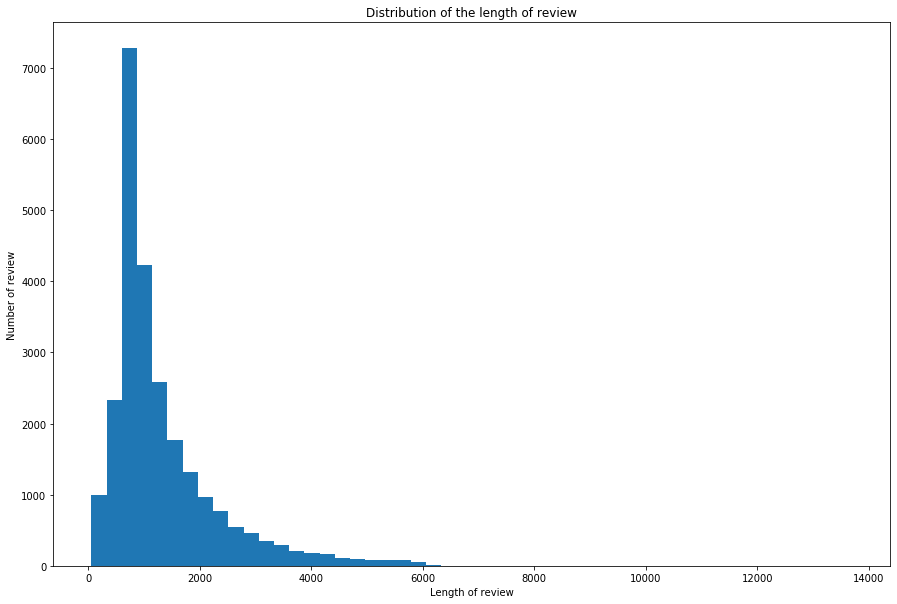

In [15]:
# plot out the distribution of review's length
plt.figure(figsize=(15, 10))
plt.hist([len(review) for review in list(x_train_ori)], 50)
plt.xlabel('Length of review')
plt.ylabel('Number of review')
plt.title('Distribution of the length of review')
plt.show()

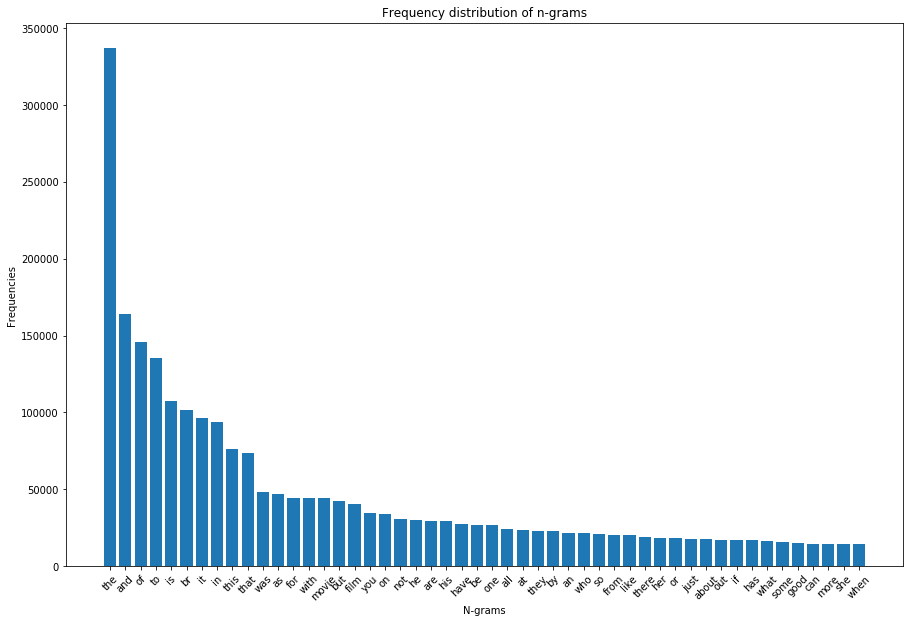

In [16]:
# plot out the most frequent's words shown in the reviews.

wd = {
    'ngram_range' : (1, 1),
    'dtype' : 'int32',
    'strip_accents' : 'unicode',
    'decode_error' : 'replace',
    'analyzer' : 'word'
}

vectorizer = CountVectorizer(**wd)
vect_texts = vectorizer.fit_transform(list(x_train_ori))
all_ngrams = vectorizer.get_feature_names()
num_ngrams = min(50, len(all_ngrams))
all_counts = vect_texts.sum(axis=0).tolist()[0]

all_ngrams, all_counts = zip(*[(n, c) for c, n in sorted(zip(all_counts, all_ngrams), reverse=True)])
ngrams = all_ngrams[:num_ngrams]
counts = all_counts[:num_ngrams]

idx = np.arange(num_ngrams)

plt.figure(figsize=(15, 10))
plt.bar(idx, counts, width=0.8)
plt.xlabel('N-grams')
plt.ylabel('Frequencies')
plt.title('Frequency distribution of n-grams')
plt.xticks(idx, ngrams, rotation=45)
plt.show()

According to the result above, it's quite obvious that those frequent words (eg: the, and , of...) are "stop words" and do not provide much information and insights for our task. Therefore, we must clean and do preprocessing of the data before sending it into the model.

# Data preprocessing

First of all, convert our data into pandas dataframes:

In [0]:
# Create train dataframe 
train_df = pd.DataFrame()
train_df['text'] = x_train_ori
train_df['label'] = y_train_ori

# Create test dataframe 
test_df = pd.DataFrame()
test_df['text'] = x_test_ori
test_df['label'] = y_test_ori

train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

In [0]:
train_df.text = train_df.text.apply(lambda r: BeautifulSoup(r, 'html.parser').get_text())
test_df.text = test_df.text.apply(lambda r: BeautifulSoup(r, 'html.parser').get_text())

In [19]:
train_df

,text,label
0,This is actually a pretty bad film. The ideolo...,0
1,Kojak meets the mafia. Telly Savales is one of...,0
2,I must say that I am fairly disappointed by th...,0
3,POPEYE AND BIG FOOT **; POPEYE'S ENGINE COMPAN...,0
4,This is probably the worst movie I have ever s...,0
...,...,...
24995,It's very hard to say just what was going on w...,1
24996,"Michelle Rodrigez was made for this movie, whe...",1
24997,"Released two years before I was born, this Osc...",1
24998,A glacier slide inside a cavernous ice mountai...,1


In [20]:
test_df

,text,label
0,I watched this because of the description and ...,0
1,Three young movie theater employees are given ...,0
2,SPOILERSI love movies. I've seen a lot of movi...,0
3,One of the few reasons to make these pointlss ...,0
4,This cosy middle class sitcom became the subje...,0
...,...,...
24995,This one of those social dramas that WB knew h...,1
24996,"Harry Langdon's ""Saturday Afternoon"" is often ...",1
24997,Jarl and Moodysson are part of an dying breed ...,1
24998,I thought this was a great action flick. A ver...,1


### First processing round: 
We are going to tokenize and filter out the followings: 

1.non-alphabetic 
2.tokens that are too short


and lastly make them all to be lowercase.

In [0]:
#load spacy English  package 
spacy.load('en')
nlp = spacy.load("en_core_web_sm", disable=['parser','ner'])


In [0]:
MIN_WORD_LEN = 3 #the minimal of word len is 3, if ones less than 3, it will be filtered out.
def text_to_words(text):

    doc = nlp(text)
    filtered = [token.orth_ for token in doc if token.is_alpha and not token.is_punct and not token.like_num and len(token)>=MIN_WORD_LEN] 
    text =  [w.lower() for w in filtered]
    #text = list(set(text))

    return text

In [23]:
# Apply the first processing round to training data
train_texts = train_df.text.values.tolist()
train_texts_words = [text_to_words(text) for text in train_texts]
print(train_texts_words[:1])

[['this', 'actually', 'pretty', 'bad', 'film', 'the', 'ideology', 'not', 'perverse', 'those', 'films', 'collins', 'made', 'later', 'however', 'main', 'misgivings', 'about', 'the', 'film', 'are', 'that', 'implausible', 'and', 'quite', 'frankly', 'boring', 'for', 'long', 'time', 'the', 'whole', 'concept', 'sas', 'man', 'joining', 'terrorists', 'for', 'particular', 'reason', 'very', 'convincing', 'and', 'you', 'help', 'wondering', 'why', 'group', 'highly', 'organized', 'terrorists', 'who', 'later', 'become', 'pretty', 'clueless', 'fall', 'for', 'the', 'film', 'starts', 'with', 'pretty', 'powerful', 'scene', 'but', 'then', 'meanders', 'for', 'quite', 'long', 'time', 'building', 'towards', 'the', 'great', 'finale', 'overall', 'think', 'who', 'dares', 'wins', 'could', 'have', 'been', 'interesting', 'minutes', 'episode', 'the', 'professionals', 'but', 'the', 'story', 'does', 'carry', 'feature', 'film', 'although', 'reasonably', 'successful', 'the', 'time', 'this', 'film', 'initiated', 'the', 

In [24]:
# Apply the first processing round to test data
test_texts = test_df.text.values.tolist()
test_texts_words = [text_to_words(text) for text in test_texts]
print(test_texts_words[:1])

[['watched', 'this', 'because', 'the', 'description', 'and', 'cover', 'art', 'and', 'yet', 'again', 'was', 'deceived', 'getting', 'sick', 'all', 'these', 'new', 'stupid', 'straight', 'dvd', 'horror', 'movies', 'once', 'blue', 'moon', 'will', 'started', 'out', 'with', 'confusing', 'scene', 'and', 'then', 'jumped', 'years', 'and', 'showed', 'couple', 'night', 'during', 'thunderstorm', 'which', 'was', 'because', 'like', 'storms', 'and', 'set', 'nice', 'mood', 'then', 'turned', 'into', 'cool', 'road', 'trip', 'where', 'they', 'ended', 'diner', 'encountering', 'bizarre', 'people', 'the', 'rest', 'got', 'weird', 'and', 'then', 'got', 'confusing', 'did', 'watch', 'til', 'the', 'end', 'but', 'was', 'even', 'more', 'confused', 'when', 'ended', 'badly', 'had', 'higher', 'hopes', 'for', 'this', 'movie', 'but', 'was', 'more', 'like', 'science', 'fiction', 'then', 'horror', 'and', 'something', 'that', 'should', 'have', 'been', 'made', 'for']]


In [25]:
%%time
# Build the bigram and trigram models for training data and testing data
# The minimum occurency of a bigram phrase should be 5
# Both the bigram and trigram phrases should have the threshold 100
train_bigram_phrases = gensim.models.Phrases(train_texts_words, min_count = 5, threshold=100) 
train_trigram_phrases = gensim.models.Phrases(train_bigram_phrases[train_texts_words], threshold=100) 
test_bigram_phrases = gensim.models.Phrases(test_texts_words, min_count = 5, threshold=100) 
test_trigram_phrases = gensim.models.Phrases(test_bigram_phrases[test_texts_words], threshold=100)

# This is a kind of technical pruning only
train_bigram_phraser = gensim.models.phrases.Phraser(train_bigram_phrases)
train_trigram_phraser = gensim.models.phrases.Phraser(train_trigram_phrases)
test_bigram_phraser = gensim.models.phrases.Phraser(test_bigram_phrases)
test_trigram_phraser = gensim.models.phrases.Phraser(test_trigram_phrases)



CPU times: user 1min 48s, sys: 451 ms, total: 1min 49s
Wall time: 1min 49s


In [0]:
# Apply the n-gram models to the data
train_texts_words = [train_trigram_phraser[train_bigram_phraser[words]] for words in train_texts_words]
test_texts_words = [test_trigram_phraser[test_bigram_phraser[words]] for words in test_texts_words]

### Second (final) round of filtering on the basis of stopwords and POS-tags, and lemmatize all tokens.

In [27]:
%%time
# Now we use spacy to do filtering based on stopwords, POS-tags and lemmatize for train data

train_filtered = []

for words in train_texts_words:
    doc = spacy.tokens.Doc(nlp.vocab, words=words)
    tagged = nlp.get_pipe("tagger")(doc)

    #keep only the lemma of tokens which are non stopwords and are either:
    #'NOUN', 'ADJ', 'VERB' or 'ADV
    lemmas = [token.lemma_ for token in tagged if not token.is_stop and (token.pos_ == "NOUN" or token.pos_ == "VERB" or token.pos_ == "ADJ" or token.pos_ == "ADV")] # you can do  this with a list comprehension or a for cycle, up to you
    lemmas = ' '.join(lemmas[:])
    train_filtered.append(lemmas)

#train_filtered = ' '.join(train_filtered[:])
print(train_filtered[0])

actually pretty bad film ideology perverse film collin later main misgiving film implausible frankly bore long time concept sas man join terrorist particular reason convincing help wonder group highly organize terrorist later pretty clueless fall film start pretty powerful scene meander long time building great finale overall think dare win interesting minute episode professional story carry feature film reasonably successful time film initiate demise collin career eighty mainly cheap dubious soldier fortune army film pity actually versatile actor end day martin shaw choose role carefully career successful
CPU times: user 2min 35s, sys: 1.5 s, total: 2min 36s
Wall time: 2min 36s


In [28]:
# similarly, do the filtering for test data

test_filtered = []

for words in test_texts_words:
    doc = spacy.tokens.Doc(nlp.vocab, words=words)
    tagged = nlp.get_pipe("tagger")(doc)

    #keep only the lemma of tokens which are non stopwords and are either:
    #'NOUN', 'ADJ', 'VERB' or 'ADV
    lemmas = [token.lemma_ for token in tagged if not token.is_stop and (token.pos_ == "NOUN" or token.pos_ == "VERB" or token.pos_ == "ADJ" or token.pos_ == "ADV")] # you can do  this with a list comprehension or a for cycle, up to you
    lemmas = ' '.join(lemmas[:])
    test_filtered.append(lemmas)

#test_filtered = ' '.join(test_filtered[:])
print(test_filtered[0])

watch description cover art deceive get sick new stupid straight dvd horror movie blue moon start confusing scene jump year show couple night thunderstorm storm set nice mood turn cool road_trip end din encounter bizarre people rest get weird get confuse watch end confused end badly high hope movie science_fiction horror


In [0]:
# create train/test 's 
# and train/test 's y 
y_train = train_df['label'].tolist()
x_train = train_filtered

y_test = test_df['label'].tolist()
x_test = test_filtered

Data preprocessing is done at this stage.
Now we will build up a classic statistic model with TF-IDF, that will be served as a baseline model for further comparison.

# 1. TFIDF + classical statistical models (random forest) - Baseline Model

## Feature extraction 

In order to extract features, we need to convert sentences to numerical vectors so that it can be analyzable for machine. There are various ways to extract features from the text. 

The most famous ones are simple Bag of Words and TF-IDF.

## Motivation and advantage of TFIDF:
In this task we will be using TF-IDF and discard Bag of words as BoW assigns equal value to the words, irrespective of their importance. On the other hand, in TF-IDF the words that are more common in one sentence and less common in other sentences should be assigned high weights, giving them more classifying power. Therefore, TFIDF could be considered as a resolved or advanced model in regards to the issue of simple BoW.

## Brief explaination of the concept behind TFIDF  
Word will be converted represented as a single scaler number based on TF-IDF scores and is logarithmically scaled inverse fraction of the documents that contain the word.

IF: term frequency that gives the count of word t in document d.

IDF: gives information about how the word is common or rare across all document.

The vector generated using TF-IDF is sparse. It gives zero TF-IDF score for the words which are not present in the document.

In [0]:
# Count Vectors as features
# create a count vectorizer object 
count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')
count_vect.fit(x_train+x_test)

# transform the training and test data using count vectorizer object
xtrain_count =  count_vect.transform(x_train)
xtest_count =  count_vect.transform(x_test)

TF-IDF can be implemented via different levels, which for example, following two levels are implemented for comparison:

a. word level

b. n-gram level (range 2,3): n represents how many words are sent in the model as a 'set' for analysis.

In [0]:
# word level 
# max_features parameter represents the most occurring 5000 words as features for training our classifier.
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000)
tfidf_vect.fit(x_train+x_test)
xtrain_tfidf =  tfidf_vect.transform(x_train)
xtest_tfidf =  tfidf_vect.transform(x_test)


In [0]:
# ngram level
tfidf_vect_ngram = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000)
tfidf_vect_ngram.fit(x_train+x_test)
xtrain_tfidf_ngram =  tfidf_vect_ngram.transform(x_train)
xtest_tfidf_ngram =  tfidf_vect_ngram.transform(x_test)

### Model building

In [0]:
# Build a function that can train and apply to different models

def train_model(classifier, feature_vector_train, label, feature_vector_valid, is_neural_net=False):
    # fit the training dataset on the classifier
    classifier.fit(feature_vector_train, label)
    
    # predict the labels on validation dataset
    predictions = classifier.predict(feature_vector_valid)
    
    return metrics.accuracy_score(predictions, y_test)

## TF-IDF with Random forest
### Motivation of using Random forest:
Random forest is consisted of multiple decision trees. Decision tree is only dealing with one single tree classifier, so it may lead to the problem of noise or ourliers. As Decision treee is not representative for the true data distribution, it is likely to affect the result of the overall classification model. Nevertheless, Random Forest resolved this issue by combining and taking multiples trees into account so that is very much robust to noise and outliers because of randomness it provides.

We will consider this model as our baseline model and the further advanced models must surpass it.

In [34]:
# RF on simple BoW
accuracy = train_model(ensemble.RandomForestClassifier(n_estimators=10), xtrain_count, y_train, xtest_count)
print("RF, Count Vectors: ", accuracy)

# RF on Word Level TF IDF Vectors
accuracy = train_model(ensemble.RandomForestClassifier(n_estimators=10), xtrain_tfidf, y_train, xtest_tfidf)
print("RF, WordLevel TF-IDF: ", accuracy)

# RF on Ngram Level TF IDF Vectors
accuracy = train_model(ensemble.RandomForestClassifier(n_estimators=10), xtrain_tfidf_ngram, y_train, xtest_tfidf_ngram)
print("RF, N-Gram Vectors: ", accuracy)

RF, Count Vectors:  0.76076
RF, WordLevel TF-IDF:  0.77596
RF, N-Gram Vectors:  0.72404


Word level has a better accuracy among is due to:

simple count vector(BoW) - too simple, values are assigned equally to each word.

n-gramm - as it do not aim to understand the context/meaning of words, it doesn't help us to gain more information.

## Drawback and takeaway from this model:
It only takes words frequency into account but neglect the context of words in regards to their meanings or order. The words will not much informative if we only implemented this model.

This is also the reason why this should be used as a baseline model ( accuracy of 0.77596) as it is way too simple when it comes to complex language analysis.

# 2. LSTM classification model
LSTM stands for Long Short Term Memory, which is one example of recurrent neural networks. The RNN model can take the context of words into account and output the possible classification or words based on the calculated possiblility given the input words or sequences.

## Motivation and advantage of LSTM model:

We do not use traditional recurrent neural network as it may encounter the issues of:

1.Vanishing gradients where the gradient signal gets so small that learning either becomes very slow or stops working altogether. 

2.Exploding gradients where is so large that it can cause learning to diverge. 

As a result, the magnitude of weights in the transition matrix can have a strong impact on the learning process and it can also make more difficult the task of learning long-term dependencies in our langauge model.

-

LSTM could resolve or improve traditional rnn by introducing a new structure called a memory cell, which consisted of an input gate, a neuron with a self-recurrent connection (a connection to itself), a forget gate and an output gate.

### Tokenization
First of all, we tokenized words in each sequence so that each word can be a token and later be sent into the model.

In [35]:
MAX_NUM_WORDS = 1000000 #my own call for assigning the parameter
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(x_train)

#split again for validation set from testing data (as suggested)
x_test_lstm, x_val, y_test_lstm, y_val = train_test_split(x_test, y_test, test_size=0.25, random_state=33)
sequences_train = tokenizer.texts_to_sequences(x_train)


print("Length of 1st training example: ", len(sequences_train[0]))
print("Maximum number of words in the training reviews: ", max([len(i) for i in sequences_train]))

Length of 1st training example:  87
Maximum number of words in the training reviews:  1233


In [36]:
sequences_test = tokenizer.texts_to_sequences(x_test_lstm)
print("Length of 1st testing example: ", len(sequences_test[0]))
print("Maximum number of words in the reviews: ", max([len(i) for i in sequences_test]))


Length of 1st testing example:  197
Maximum number of words in the reviews:  915


In [37]:
sequences_val = tokenizer.texts_to_sequences(x_val)
print("Length of 1st training example: ", len(sequences_val[0]))
print("Maximum number of words in the training reviews: ", max([len(i) for i in sequences_val]))

Length of 1st training example:  53
Maximum number of words in the training reviews:  908


In [38]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 60435 unique tokens.


### Padding
padding is needed is because each sequence/review has different length. However, machine learning algorithms require all the training example with a fixed length.

As a result, we need to make all length identical by padding the short ones to the predifined values.

In [39]:
MAX_SEQUENCE_LENGTH = 256 #assign manually the length we wanted to pad to
 
x_train_seq = pad_sequences(sequences_train, maxlen=MAX_SEQUENCE_LENGTH)
x_val_seq = pad_sequences(sequences_val, maxlen=MAX_SEQUENCE_LENGTH)
x_test_seq = pad_sequences(sequences_test, maxlen=MAX_SEQUENCE_LENGTH)

print("Length of 1st training example: ", len(x_train_seq[0]))
print("Length of 5th training example: ",  len(x_train_seq[5]))
print("Length of 1th testing example: ",  len(x_test_seq[0]))
print("Length of 5th training example: ",  len(x_test_seq[5]))
print("Length of 1st validation example: ", len(x_val_seq[0]))
print("Length of 5th validation example: ",  len(x_val_seq[5]))

y_train_labels = to_categorical(np.asarray(y_train))
y_val_labels = to_categorical(np.asarray(y_val))
y_test_labels = to_categorical(np.asarray(y_test_lstm))


Length of 1st training example:  256
Length of 5th training example:  256
Length of 1th testing example:  256
Length of 5th training example:  256
Length of 1st validation example:  256
Length of 5th validation example:  256


In [0]:
# set up parameters
EMBEDDING_DIM = 100
lstm_size = 64

In [41]:
# Initialize session
from keras import backend as K
K.clear_session()

session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)


### Embedding 
The Embedding layer is used to create word vectors for incoming words. It sits between the input and the LSTM layer. The output of the Embedding layer is the input to the LSTM layer.)

The weights for the Embedding layer can either be initialized with random values.


In [0]:
# we start off with an efficient embedding layer which maps our vocab indices into embedding_dims dimensions
embedding_layer = Embedding(len(word_index)+1,
                            EMBEDDING_DIM,
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

### Model building

In [43]:
# the parameters below are self assgined numbers
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
x = Conv1D(128, 5, activation='relu')(embedded_sequences)
x = Dropout(0.2)(x)
x = MaxPooling1D(5)(x)
x = Bidirectional(LSTM(lstm_size, activation='relu'))(x)
x = Dropout(0.2)(x)
output = Dense(2, activation='softmax')(x) #project onto a single unit output layer, and squash it with a softmax
model = Model(inputs=sequence_input, outputs=output)



Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



In [44]:
# Loss 
loss ='categorical_crossentropy' 

# Optimizer
optimizer = 'adam'
 
# Compilation
model.compile(loss= loss, optimizer = optimizer, metrics = ['accuracy'])

### Train Model

In [45]:
lstm=model.fit(x_train_seq, y_train_labels, validation_data=(x_val_seq, y_val_labels), batch_size=128, epochs=5)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 25000 samples, validate on 6250 samples
Epoch 1/5




25000/25000 [==============================] - 34s 1ms/step - loss: 0.6216 - acc: 0.6434 - val_loss: 0.5680 - val_acc: 0.7206
Epoch 2/5
25000/25000 [==============================] - 27s 1ms/step - loss: 0.5181 - acc: 0.7461 - val_loss: 0.5146 - val_acc: 0.7416
Epoch 3/5
25000/25000 [==============================] - 27s 1ms/step - loss: 0.4592 - acc: 0.7852 - val_loss: 0.4467 - val_acc: 0.7952
Epoch 4/5
25000/25000 [==============================] - 27s 1ms/step - loss: 0.3847 - acc: 0.8329 - val_loss: 0.4205 - val_acc: 0.8114
Epoch 5/5
25000/25000 [==============================] - 27s 1ms/step - loss: 0.3263 - acc: 0.8646 - val_loss: 0.4521 - val_acc: 0.7930


From the training result above we can see that the model is learning and improved over epochs. Nevertheless, the training set is getting more overfit since the validation set is not improving that much comparing to the training set.

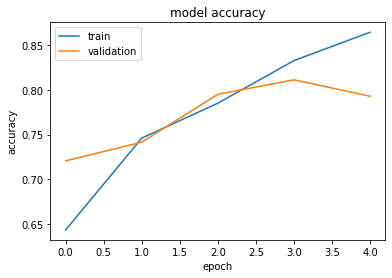

In [46]:
# plot the accuracy with respective epoch
plt.plot(lstm.history['acc'])
plt.plot(lstm.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

According to the graph, we can see that training set surpasses testing set in epoch 2 and is extremely overfitting after the point of epoch 3. (validating set is decreasing)

In [0]:
pred_lstm = model.predict(x_test_seq)

In [0]:
pred_lstm_labels  = (pred_lstm>0.5) #threshold=0.5

Text(15.380000000000003, 0.5, 'predicted label')

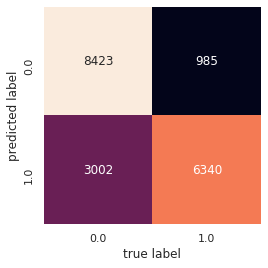

In [49]:
# plot the confusion matrix to see how the model performed
from sklearn.metrics import classification_report,confusion_matrix
import seaborn as sns

mat = confusion_matrix(pred_lstm_labels.argmax(axis=1), y_test_labels.argmax(axis=1))
plt.figure(figsize=(4, 4))
sns.set()
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=np.unique(y_test_labels),
            yticklabels=np.unique(y_test_labels))
plt.xlabel('true label')
plt.ylabel('predicted label')

* True positive: for correctly predicted neg-event values = 8423
* False positive: for incorrectly predicted neg-event values = 3002
* True negative” for correctly predicted pos-event values = 8423
* False negative” for incorrectly predicted pos-event values = 985

In [50]:
#Final result of lstm model
print(classification_report(pred_lstm_labels,y_test_labels))

              precision    recall  f1-score   support

           0       0.90      0.74      0.81     11425
           1       0.68      0.87      0.76      7325

   micro avg       0.79      0.79      0.79     18750
   macro avg       0.79      0.80      0.78     18750
weighted avg       0.81      0.79      0.79     18750
 samples avg       0.79      0.79      0.79     18750



* Precision=Σ True positive
/
Σ Predicted condition positive 

 (The one we identified as positive is indeed true positive. This focuses on how precise is our prediction) 


* Recall=Σ True positive
/
Σ Condition positiv

 (The one should be positive and we successfully identified as positive. This focuses on how general the model performs.)

We improved our accurancy to nearly 79 percent(F1 score) with random initialized weights for LSTM model.

# 3. LSTM with pretrained glove vectors
As the previous LSTM we used the initialized weights for the Embedding layer with random values, for the third model we would like to rely on pretrained third-party source which initialized the word embeddings with GloVe vectors, hoping to improve the accuracy. (others remain unchanged)

Using third party embeddings to build word vectors is as a form of transfer learning, since we would be able to transfer the semantic information between words that was learned during the embedding process and utilize it for our own model.

(Transfer learning is a technique that enables the transfer of knowledge learned from one dataset to another)

In [51]:
#download zip file via link
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2019-12-21 22:28:11--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2019-12-21 22:28:11--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2019-12-21 22:28:12--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [52]:
!unzip glove*.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [53]:
!ls #Glove package has different embedding size of vectors: 100d, 200d, 300d and 50d. (I will use 100d)

aclImdb		glove.6B.100d.txt  glove.6B.300d.txt  glove.6B.zip
aclImdb_v1.tar	glove.6B.200d.txt  glove.6B.50d.txt   sample_data


In [54]:
print('Indexing word vectors.')

# create a array that can store the glove pretrained vectors
embeddings_index = {}
f = open('glove.6B.100d.txt', encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index)) 
#It was trained on a dataset with a vocabulary of 400 thousand words.

Indexing word vectors.
Found 400000 word vectors.


In [0]:
# Initialize session
from keras import backend as K
K.clear_session()

session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

In [0]:
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [0]:
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix], #add weights from glove
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

In [0]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
x = Conv1D(128, 5, activation='relu')(embedded_sequences)
x = Dropout(0.2)(x)
x = MaxPooling1D(5)(x)
x = Bidirectional(LSTM(64, activation='relu'))(x)
x = Dropout(0.2)(x)
output2 = Dense(2, activation='softmax')(x) 

model2 = Model(sequence_input, output2)

In [0]:
# Loss 

loss ='categorical_crossentropy' 

# Optimizer
optimizer = 'adam' 
 
# Compilation

model2.compile(loss= loss, optimizer = optimizer, metrics = ['accuracy'])

### Model building (same parameters are used as the previous lstm model)

In [60]:
lstm_glove=model2.fit(x_train_seq, y_train_labels, validation_data=(x_val_seq, y_val_labels), batch_size=128, epochs=5)

Train on 25000 samples, validate on 6250 samples
Epoch 1/5
25000/25000 [==============================] - 29s 1ms/step - loss: 0.5115 - acc: 0.7486 - val_loss: 0.4332 - val_acc: 0.8141
Epoch 2/5
25000/25000 [==============================] - 27s 1ms/step - loss: 0.3972 - acc: 0.8233 - val_loss: 0.3639 - val_acc: 0.8408
Epoch 3/5
25000/25000 [==============================] - 27s 1ms/step - loss: 0.3579 - acc: 0.8444 - val_loss: 0.3854 - val_acc: 0.8331
Epoch 4/5
25000/25000 [==============================] - 27s 1ms/step - loss: 0.3215 - acc: 0.8620 - val_loss: 0.3651 - val_acc: 0.8389
Epoch 5/5
25000/25000 [==============================] - 28s 1ms/step - loss: 0.2810 - acc: 0.8807 - val_loss: 0.3451 - val_acc: 0.8501


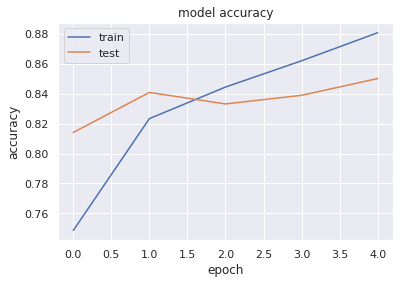

In [61]:
# summarize history for accuracy
plt.plot(lstm_glove.history['acc'])
plt.plot(lstm_glove.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
pred_lstm_glove = model2.predict(x_test_seq)

In [0]:
pred_lstm_glove_labels  = (pred_lstm_glove>0.5) #threshold=0.5

Text(15.380000000000003, 0.5, 'predicted label')

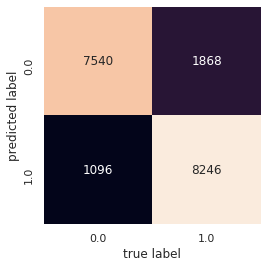

In [64]:
mat = confusion_matrix(pred_lstm_glove_labels.argmax(axis=1), y_test_labels.argmax(axis=1))
plt.figure(figsize=(4, 4))
sns.set()
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=np.unique(y_test_labels),
            yticklabels=np.unique(y_test_labels))
plt.xlabel('true label')
plt.ylabel('predicted label')

In [65]:
print(classification_report(pred_lstm_glove_labels,y_test_labels))

              precision    recall  f1-score   support

           0       0.80      0.87      0.84      8636
           1       0.88      0.82      0.85     10114

   micro avg       0.84      0.84      0.84     18750
   macro avg       0.84      0.84      0.84     18750
weighted avg       0.85      0.84      0.84     18750
 samples avg       0.84      0.84      0.84     18750



The accurancy has been improved to approx. 85 percent (F1 score) with pretrained glove vectors for LSTM model.

## Drawback and takeaway
Although we achieved a better accurancy, pretrained glove vectors with lstm model is not capable of dealing with unknown word. Therefore, a more advanved model will be introduced at the next stage.

# 4. FastText model (with ktrain)

## Motivation of fasttext model
The fastText library from Facebook has very easy to use scripts to create a text classification model.
It supports  not only supervised (classifications) but also unsupervised (embedding) representations of words and sentences.  Given this form of embeddings generation it can generate embeddings for any word that it didn’t even come across in the corpus it was trained on, which can solve the issue from the previous glove model.

## Advantage and algorithms behind fasttext model
Fasttext is efficient in learning of word representations and text classification and is relatively fast compares to implementing deep leaning model. 

It can output a vector for a word that is not in the pre-trained model because it constructs the vector for a word from n-gram vectors that constitute a word(the training process trains n-grams, not full word). Therefore, even if a word is not present in corpus, it can still construct a vector for that word by adding the n-grams that constitute a word

## ktrain
Its main purpose is to hide away much of the syntactic clutter in building default pipelines for preprocessing data, training a predictor as well as it's deployment. It helps to speed up the process.

In [66]:
import ktrain
from ktrain import text as txt

using Keras version: 2.2.4-tf


In [67]:
# load data(raw) directly from the downloaded folder
(x_train_fasttext, y_train_fasttext), (x_test_fasttext, y_test_fasttext), preproc = txt.texts_from_folder('aclImdb',
                                                                     maxlen=256, 
                                                                     max_features=20000,
                                                                     ngram_range=1,
                                                                     classes=['pos', 'neg'])

detected encoding: utf-8
language: en
Word Counts: 88582
Nrows: 25000
25000 train sequences
Average train sequence length: 231
x_train shape: (25000,256)
y_train shape: (25000,2)
25000 test sequences
Average test sequence length: 224
x_test shape: (25000,256)
y_test shape: (25000,2)


In [68]:
ft_model= txt.text_classifier('fasttext', (x_train_fasttext, y_train_fasttext))

Is Multi-Label? False
compiling word ID features...
max_features is 20000
maxlen is 256
done.


In [0]:

fasttext_learner = ktrain.get_learner(ft_model, train_data=(x_train_fasttext, y_train_fasttext), val_data=(x_test_fasttext, y_test_fasttext))

simulating training for different learning rates... this may take a few moments...
Train on 25000 samples
Epoch 1/1024
25000/25000 [==============================] - 5s 194us/sample - loss: 0.9179 - acc: 0.5038
Epoch 2/1024
25000/25000 [==============================] - 5s 181us/sample - loss: 0.7014 - acc: 0.5899
Epoch 3/1024
 8992/25000 [=========>....................] - ETA: 2s - loss: 0.8440 - acc: 0.5008

done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


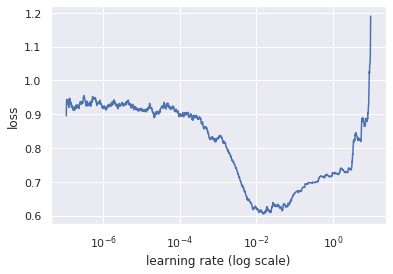

In [70]:
#instantiate a Learner object and call the lr_find and lr_plot methods to help identify a good learning rate.
fasttext_learner.lr_find()
fasttext_learner.lr_plot()

In [71]:
# Train the model using the found parameters
fasttext_learner.autofit(0.005, 2)




begin training using triangular learning rate policy with max lr of 0.005...
Train on 25000 samples, validate on 25000 samples
Epoch 1/2
25000/25000 [==============================] - 7s 281us/sample - loss: 0.5962 - acc: 0.6888 - val_loss: 0.3952 - val_acc: 0.8316
Epoch 2/2
25000/25000 [==============================] - 7s 270us/sample - loss: 0.4247 - acc: 0.8107 - val_loss: 0.3473 - val_acc: 0.8508


The training achieved accuracy of 0.8508.

## Drawback and takeaway
Its accuracy could be low with small datasets and did not use pre-trained word-embeddings.
For further experimentt, I will later use BERT model to see if the accuracy can be improved.

# BERT based model (with ktrain)
Bert stands for "Bidirectional Encoder Representations from Transformers". 
## Motivation and advantage of Bert model
It is another transform learning technique which information learned from one dataset can be transferred to other datasets for specific tasks. In general it can outperform other models and reach a better accuracy with simple implementaion.

In [72]:
# load data(raw) directly from the downloaded folder
# BERT can handle a maximum length of 512, but I will use less to reduce memory and improve speed
# and also to be consistent to the same max len with above models

(x_train_bert, y_train_bert), (x_test_bert, y_test_bert), preproc = txt.texts_from_folder('aclImdb',
                                                                     maxlen=MAX_SEQUENCE_LENGTH, 
                                                                     preprocess_mode='bert',
                                                                     classes=['pos', 'neg'])
#preproc is the built-in preprocessing part that can be used later in test set


detected encoding: utf-8
downloading pretrained BERT model (uncased_L-12_H-768_A-12.zip)...
[██████████████████████████████████████████████████]
extracting pretrained BERT model...
done.

cleanup downloaded zip...
done.

preprocessing train...
language: en


preprocessing test...
language: en


In [73]:
bert_ktrain = txt.text_classifier('bert', train_data=(x_train_bert, y_train_bert), preproc=preproc)
learner = ktrain.get_learner(bert_ktrain, train_data=(x_train_bert, y_train_bert), batch_size=6)
#get_learner uses the function in ktrain to load the pretrained BERT model 
#with a randomly initialized final Dense layer

Is Multi-Label? False
maxlen is 256
done.


## Train the model 
using one of the three learning rates recommended in the BERT paper: 
5e-5, 3e-5, or 2e-5.

For bert model, I used one of the recommended learning rate.
Another alternative is to also use the lr.find function(shown in fasttext model)to find out the optimal training parameters. 

In [74]:

#learner.lr_find()
#learner.lr_plot()

learner.fit_onecycle(2e-5, 3)

#this function linearly increases the learning rate for the first half of training 
#and then decreases the learning rate for the latter half.



begin training using onecycle policy with max lr of 2e-05...
Train on 25000 samples
Epoch 1/3
25000/25000 [==============================] - 919s 37ms/sample - loss: 0.2981 - acc: 0.8698
Epoch 2/3
25000/25000 [==============================] - 913s 37ms/sample - loss: 0.1905 - acc: 0.9276
Epoch 3/3
25000/25000 [==============================] - 915s 37ms/sample - loss: 0.0662 - acc: 0.9786


In [75]:
learner.validate(val_data=(x_test_bert, y_test_bert))

              precision    recall  f1-score   support

           0       0.93      0.92      0.92     12500
           1       0.92      0.93      0.92     12500

    accuracy                           0.92     25000
   macro avg       0.92      0.92      0.92     25000
weighted avg       0.92      0.92      0.92     25000



array([[11462,  1038],
       [  905, 11595]])

With Bert model, we achieved accuracy over 90% （92%). 

By looking at the result I would say Bert is performing relatively good in comparision with the previous 4 less handy models.

## Drawback and takeaway
Although BERT’s performance is indeed impressive, it is rather time consuming and is comparatively slow in terms of both training and inference. 
However, in most cases, Bert is a good state of art model that is worth to be implemented when considering its trade-off with its slowness in regards to its performance.

# Future improvement
1. For this project, we only use BERT-base model but there is another possibility to use BERT-large model which will hopefully perform even better.

2. For model 4 and 5, I did not use previous preprocessed data but directly load the train and test data from the folder is because I found out the performances are better if no self-preprocessing is applied.
I am not certain why but I assumed that the preprocessing I did is not that helpful when using Fasttext and bert model. Could be that the built in preprocessing in those models are even appropriate than what I did manually.
Therefore, for further improvement I would try to find out how may I preprocess the data that will yield better performance than the built in function.